# Load libraries

In [1]:
# !pip install meteocalc

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import gc
import irradiance
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like

warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [3]:
def add_lag_feature(weather_df, cols, window=3):
    
    group_df = weather_df.groupby('site_id')
    
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]
    return weather_df

# Load data

Reduce memory

In [4]:
path = '../data'

In [5]:
building = pd.read_csv(f'{path}/ashrae/building_metadata.csv')
d_types = {'building_id': np.int16,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16}

for feature in d_types:
    building[feature] = building[feature].astype(d_types[feature])
    
building['site_id'] = building['site_id'].replace({8:0,11:7})

Site location

In [6]:
cities = pd.read_csv(f'{path}/cities_info.csv')
cities['location'] = cities['location'].str.lower()
site_mapping = cities['location'].to_dict()
cities['lat_long'] = cities['lat_long'].apply(lambda x: x[1:-1].split(','))
cities['latitude'] = cities['lat_long'].apply(lambda x: float(x[0]))
cities['longitude'] = cities['lat_long'].apply(lambda x: float(x[1]))

building = pd.merge(building, cities[['site_id','country']], how='left')

Combine weather and input potentially missing timestamps

In [7]:
weather_train = pd.read_csv(f'{path}/ashrae/weather_train.csv')
weather_test = pd.read_csv(f'{path}/ashrae/weather_test.csv')

weather = pd.concat([weather_train,weather_test],axis=0)
del weather_train,weather_test

Reduce memory

In [8]:
d_types = {'site_id': np.int8,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    weather[feature] = weather[feature].astype(d_types[feature])

Ensure all timestamps are there

In [9]:
combination = pd.DataFrame(list(itertools.product(weather['site_id'].unique(), 
                                                  weather['timestamp'].unique(),)), 
                           columns=['site_id','timestamp'])
weather = pd.merge(combination, weather, how='left')

weather['timestamp'] = pd.to_datetime(weather['timestamp'], format='%Y-%m-%d %H:%M:%S')
weather = weather.sort_values(['site_id','timestamp'])

Remove duplicated sites

In [10]:
weather = weather[~weather['site_id'].isin([11,8])]

In [11]:
gc.collect();

# Fill weather with external data  
Thanks to 
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature

Create new variables

In [12]:
for f in ['sea_level_pressure','dew_temperature','wind_speed','cloud_coverage',
          'wind_direction','precip_depth_1_hr','air_temperature']:
    if f'new_{f}' not in weather.columns:
        weather[f'new_{f}']= weather[f]
        
weather['uvIndex'] = np.nan
weather['cloudCover'] = np.nan
weather['humidity'] = np.nan

# Irish weather data

In [13]:
irish_weather = pd.read_csv(f'{path}/irish-weather-hourly-data/dublin_weather_2016_2018.csv')
irish_weather['timestamp'] = pd.to_datetime(irish_weather['timestamp'])
irish_weather = irish_weather.set_index('timestamp')

rows = weather['site_id'].eq(12)
irish_weather = irish_weather.loc[weather.loc[rows,'timestamp']]

# Dark sky data

In [14]:
all_df = pd.read_csv(f'{path}/Darksky/all_data.csv')
all_df = all_df.rename({'dewPoint':'dew_temperature',
                        'precipIntensity':'precip_depth_1_hr',
                        'pressure':'sea_level_pressure',
                        'temperature':'air_temperature',
                        'windBearing':'wind_direction',
                        'windSpeed':'wind_speed'}, axis=1)

all_df['timestamp'] = pd.to_datetime(all_df['time'],unit='s')

# Duplicate data for washington
washington = all_df[all_df['site_id'].eq(3)].copy()
washington['site_id']=6
all_df = pd.concat([all_df,washington],axis=0)

In [15]:
for i in all_df['site_id'].unique():
    rows = weather['site_id'].eq(i) 
    subset = all_df[all_df['site_id'].eq(i)].copy()
    subset = subset[~subset['timestamp'].duplicated()]

    for f in ['sea_level_pressure','dew_temperature',
              'wind_direction','precip_depth_1_hr',
              'air_temperature','wind_speed','cloud_coverage']:
        if i == 12: # Dublin is separate
            weather.loc[rows,f'new_{f}'] = irish_weather[f].values
        elif f!='cloud_coverage':       
            merged = pd.merge(weather.loc[rows,][['timestamp']].copy(), 
                              subset[['timestamp',f]], how='left', on=['timestamp'])
            weather.loc[rows,f'new_{f}'] = merged[f].values
            
#             # Verify correlation with original weather data
#             corr = pd.DataFrame({'old':weather.loc[rows,f'new_{f}'],'new':merged[f].values}).corr()
#             corr = corr.loc['old','new'].round(3)
            
#             # Number of NA prior to impute
#             nb_nan = weather.loc[rows,f'new_{f}'].isna().sum()

#             # Impute NAs
#             weather.loc[rows,f'new_{f}'] = np.where(weather.loc[rows,f'new_{f}'].isna(),
#                                                         merged[f].values,
#                                                         weather.loc[rows,f'new_{f}'])

    for f in ['uvIndex','humidity','cloudCover']:
        if i == 12 and f =='humidity':
            weather.loc[rows,'humidity'] = irish_weather['rhum'].values
        else :
            merged = pd.merge(weather.loc[rows,][['timestamp']].copy(), subset, how='left', on=['timestamp'])
            weather.loc[rows,f] = merged[f].values
        
del subset, merged, rows

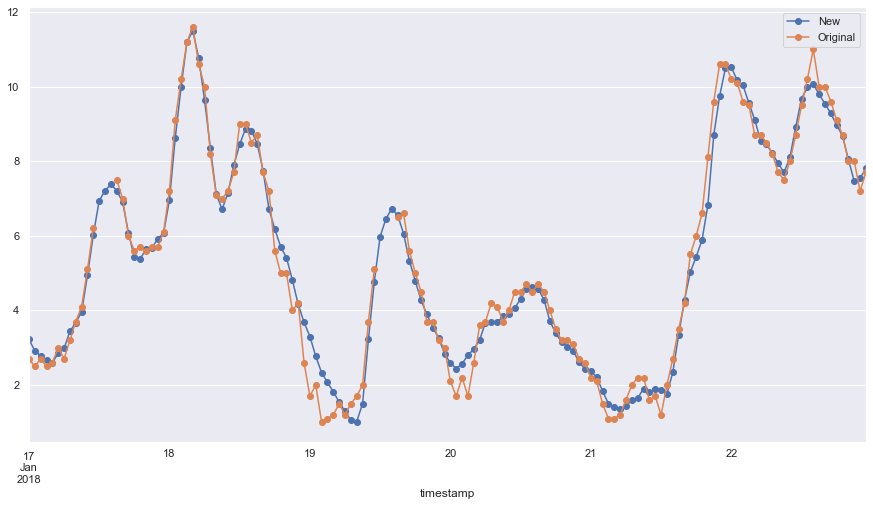

In [16]:
plt.figure(figsize=(15,8))
start = '2018-01-17'
end = '2018-01-22'

site_id = 1

weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['new_air_temperature']\
                .plot(figsize=(15,8),label='New',marker='o')
weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['air_temperature']\
                .plot(figsize=(15,8),label='Original',marker='o')
plt.legend()
plt.show()


# Interpolate NA linearly

In [17]:
before = weather.isna().groupby(weather['site_id']).sum().transpose()

In [18]:
max_hour_fill_na = 4

for f in [
    'sea_level_pressure','dew_temperature',
    'wind_direction','precip_depth_1_hr',
    'air_temperature','wind_speed','cloud_coverage',
    'new_sea_level_pressure','new_dew_temperature',
    'new_wind_speed','new_wind_direction','new_precip_depth_1_hr',
    'new_air_temperature','new_cloud_coverage','uvIndex','humidity','cloudCover']:
    print("Sarting ",f)
    fill_na_df = {}

    # If less than 3 NA in a row, interpolate linearly
    for site_id, S in weather.set_index(['site_id', 'timestamp'])[f].unstack(level=0).iteritems():
        is_na = S.isna().astype(int)
        NA_session_id = is_na.diff().eq(1).cumsum()
        NA_in_a_row = (is_na).groupby(NA_session_id).cumsum()*is_na
        NA_in_a_row = NA_in_a_row.groupby(NA_session_id).transform('max')*is_na
        fill_na_df[site_id] = pd.Series(np.where(NA_in_a_row.le(max_hour_fill_na),
                                                 S.interpolate(method='linear'), 
                                                 np.nan), 
                                        index=S.index)

    fill_na_df = pd.DataFrame(fill_na_df)
    fill_na_df.index = pd.to_datetime(fill_na_df.index, format='%Y-%m-%d %H:%M:%S')
    fill_na_df = fill_na_df.stack().reset_index()
    fill_na_df.columns = ['timestamp','site_id',f]

    fill_na_df = pd.merge(weather[['site_id','timestamp']], fill_na_df, how='left', on=['site_id','timestamp'])
    weather[f] = fill_na_df[f].values

Sarting  sea_level_pressure
Sarting  dew_temperature
Sarting  wind_direction
Sarting  precip_depth_1_hr
Sarting  air_temperature
Sarting  wind_speed
Sarting  cloud_coverage
Sarting  new_sea_level_pressure
Sarting  new_dew_temperature
Sarting  new_wind_speed
Sarting  new_wind_direction
Sarting  new_precip_depth_1_hr
Sarting  new_air_temperature
Sarting  new_cloud_coverage
Sarting  uvIndex
Sarting  humidity
Sarting  cloudCover


In [19]:
before - weather.isna().groupby(weather['site_id']).sum().transpose()

site_id,0,1,2,3,4,5,6,7,9,10,12,13,14,15
site_id,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timestamp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
air_temperature,3.0,60.0,2.0,13.0,4.0,74.0,26.0,312.0,65.0,42.0,48.0,5.0,6.0,289.0
cloud_coverage,3694.0,1040.0,2433.0,11044.0,1176.0,1847.0,2077.0,0.0,2043.0,1454.0,118.0,3211.0,1859.0,1519.0
dew_temperature,3.0,60.0,4.0,16.0,9.0,75.0,26.0,386.0,72.0,42.0,48.0,5.0,6.0,293.0
precip_depth_1_hr,16.0,0.0,14.0,36.0,39.0,0.0,36.0,701.0,31.0,63.0,0.0,28.0,23.0,1182.0
sea_level_pressure,255.0,134.0,61.0,518.0,196.0,0.0,576.0,357.0,773.0,283.0,110.0,326.0,358.0,504.0
wind_direction,727.0,53.0,1760.0,412.0,313.0,857.0,2126.0,312.0,6348.0,1538.0,51.0,675.0,760.0,944.0
wind_speed,2.0,45.0,15.0,19.0,4.0,76.0,102.0,312.0,355.0,180.0,48.0,5.0,54.0,320.0
new_sea_level_pressure,40.0,34.0,39.0,35.0,38.0,32.0,35.0,37.0,61.0,47.0,0.0,40.0,36.0,59.0


https://www.kaggle.com/ragnar123/another-1-08-lb-no-leak

In [20]:
weather["day"] = weather["timestamp"].dt.day
weather["month"] = weather["timestamp"].dt.month
weather.set_index(['site_id','day','month'], inplace=True)

for f in [
    'sea_level_pressure','dew_temperature',
    'wind_direction','precip_depth_1_hr',
    'air_temperature','wind_speed','cloud_coverage',
    'new_sea_level_pressure','new_dew_temperature',
    'new_wind_speed','new_wind_direction','new_precip_depth_1_hr',
    'new_air_temperature','new_cloud_coverage','uvIndex','humidity','cloudCover']: 
    print("Sarting ",f)
    filler = weather.groupby(['site_id','day','month'])[f].mean()
    filler = pd.DataFrame(filler.fillna(method='ffill'),columns=[f])
    weather.update(filler,overwrite=False)
    
weather = weather.reset_index().drop(['day','month'],axis=1)

Sarting  sea_level_pressure
Sarting  dew_temperature
Sarting  wind_direction
Sarting  precip_depth_1_hr
Sarting  air_temperature
Sarting  wind_speed
Sarting  cloud_coverage
Sarting  new_sea_level_pressure
Sarting  new_dew_temperature
Sarting  new_wind_speed
Sarting  new_wind_direction
Sarting  new_precip_depth_1_hr
Sarting  new_air_temperature
Sarting  new_cloud_coverage
Sarting  uvIndex
Sarting  humidity
Sarting  cloudCover


In [21]:
weather.isna().groupby(weather['site_id']).sum().transpose()

site_id,0,1,2,3,4,5,6,7,9,10,12,13,14,15
site_id,False,False,False,False,False,False,False,False,False,False,False,False,False,False
timestamp,False,False,False,False,False,False,False,False,False,False,False,False,False,False
air_temperature,False,False,False,False,False,False,False,False,False,False,False,False,False,False
cloud_coverage,False,False,False,False,False,False,False,False,False,False,False,False,False,False
dew_temperature,False,False,False,False,False,False,False,False,False,False,False,False,False,False
precip_depth_1_hr,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sea_level_pressure,False,False,False,False,False,False,False,False,False,False,False,False,False,False
wind_direction,False,False,False,False,False,False,False,False,False,False,False,False,False,False
wind_speed,False,False,False,False,False,False,False,False,False,False,False,False,False,False
new_sea_level_pressure,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Plot example

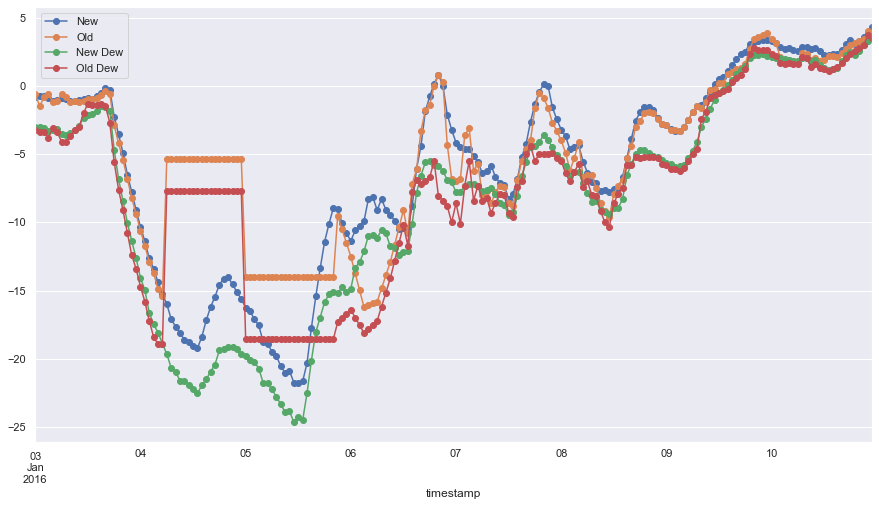

In [22]:
plt.figure(figsize=(15,8))
start = '2016-01-03'
end = '2016-01-10'

site_id = 7

weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['new_air_temperature']\
                .plot(figsize=(15,8),label='New',marker='o')
weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['air_temperature']\
                .plot(figsize=(15,8),label='Old',marker='o')
weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['new_dew_temperature']\
                .plot(figsize=(15,8),label='New Dew',marker='o')
weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['dew_temperature']\
                .plot(figsize=(15,8),label='Old Dew',marker='o')

plt.legend()
plt.show()

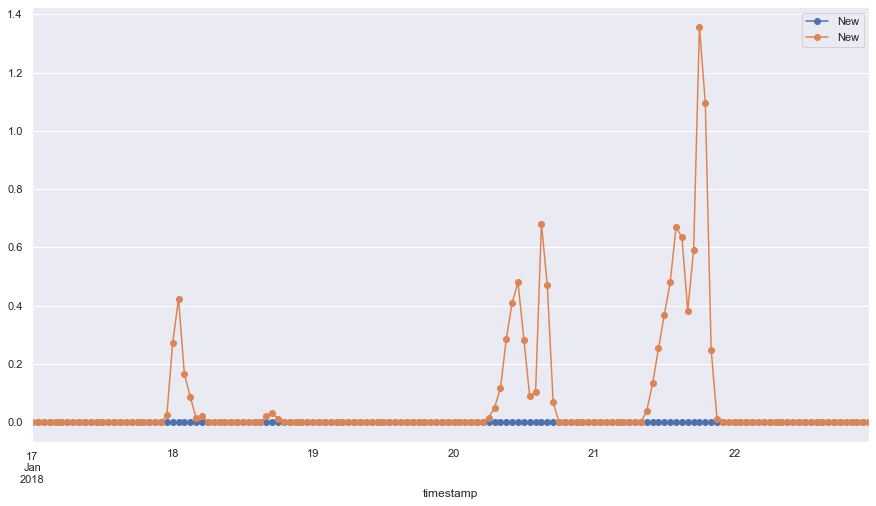

In [23]:
plt.figure(figsize=(15,8))
start = '2018-01-17'
end = '2018-01-22'

site_id = 1

weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['precip_depth_1_hr']\
                .plot(figsize=(15,8),label='New',marker='o')
weather[weather['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['new_precip_depth_1_hr']\
                .plot(figsize=(15,8),label='New',marker='o')
plt.legend()
plt.show()


# Create solar variables

https://www.esrl.noaa.gov/gmd/grad/solcalc/solareqns.PDF

In [24]:
weather = pd.merge(weather, cities[['site_id','latitude','longitude']], how='left')
weather['unix_ts'] = weather['timestamp'].astype(int).div(1000000000).astype(int)
weather['irradiance'] = weather.apply(lambda x: irradiance.get_irradiance(x['latitude'],
                                                                          x['longitude'],
                                                                          x['unix_ts']), axis=1)

weather['irradiance_cloud'] = weather['irradiance']*(1-weather['cloudCover'])

#### Using the `meteocalc` library

In [25]:
ms_to_mph = 2.23694
weather['feels_like'] = weather.apply(lambda x: feels_like(Temp(x['air_temperature'],'c'),
                                                           x['humidity'],
                                                           x['wind_speed']*ms_to_mph), axis=1).astype(float)
weather['feels_like'] = (weather['feels_like']-32)*5/9

weather['new_feels_like'] = weather.apply(lambda x: feels_like(Temp(x['new_air_temperature'],'c'),
                                                           x['humidity'],
                                                           x['wind_speed']*ms_to_mph), axis=1).astype(float)
weather['new_feels_like'] = (weather['new_feels_like']-32)*5/9

#### Using sunrise sunset calculations

In [26]:
radiance = pd.read_csv(f"{path}/dates_related/radiance.csv",
                       parse_dates=['local_time','utc_time'], index_col=0)

In [27]:
df = pd.merge(weather, radiance,how='left',left_on=['timestamp','site_id'],right_on=['utc_time','site_id'])

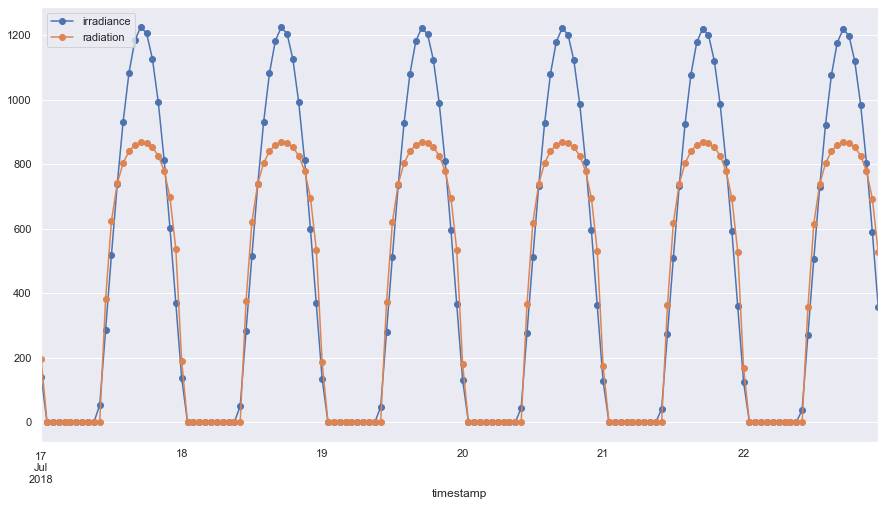

In [28]:
plt.figure(figsize=(15,8))
start = '2018-07-17'
end = '2018-07-22'

site_id = 15

df[df['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['irradiance']\
                .plot(figsize=(15,8),label='irradiance',marker='o')
df[df['site_id']==site_id]\
                .set_index('timestamp').loc[start:end]['radiation']\
                .plot(figsize=(15,8),label='radiation',marker='o')
plt.legend()
plt.show()

In [30]:
df.drop(['local_time','utc_time','unix_ts'],axis=1,inplace=True)

# Add lagged features

In [31]:
df = add_lag_feature(df, ['air_temperature', 'cloudCover'], window = 72)

# Modify wind

In [32]:
beaufort = [(0, 0, 0.3), 
            (1, 0.3, 1.6), 
            (2, 1.6, 3.4), 
            (3, 3.4, 5.5), 
            (4, 5.5, 8), 
            (5, 8, 10.8), 
            (6, 10.8, 13.9), 
            (7, 13.9, 17.2), 
            (8, 17.2, 20.8), 
            (9, 20.8, 24.5), 
            (10, 24.5, 28.5), 
            (11, 28.5, 33), 
            (12, 33, 200)]

for item in beaufort:
    df.loc[df['wind_speed'].ge(item[1]) & df['wind_speed'].lt(item[2]), 'beaufort_scale'] = item[0]

df['wind_direction_cos'] = np.cos(2*np.pi*df['wind_direction']/360)
df['wind_direction_sin'] = np.sin(2*np.pi*df['wind_direction']/360)
df['new_wind_direction_cos'] = np.cos(2*np.pi*df['new_wind_direction']/360)
df['new_wind_direction_sin'] = np.sin(2*np.pi*df['new_wind_direction']/360)

df.drop(columns=['wind_direction','new_wind_direction'],inplace=True)

# Save 

In [33]:
for f in df.dtypes[df.dtypes=='float16'].index:
    df[f] = df[f].astype(np.float32)

In [35]:
df.to_feather(f'{path}/Prepared_data/weather_bis.feather')